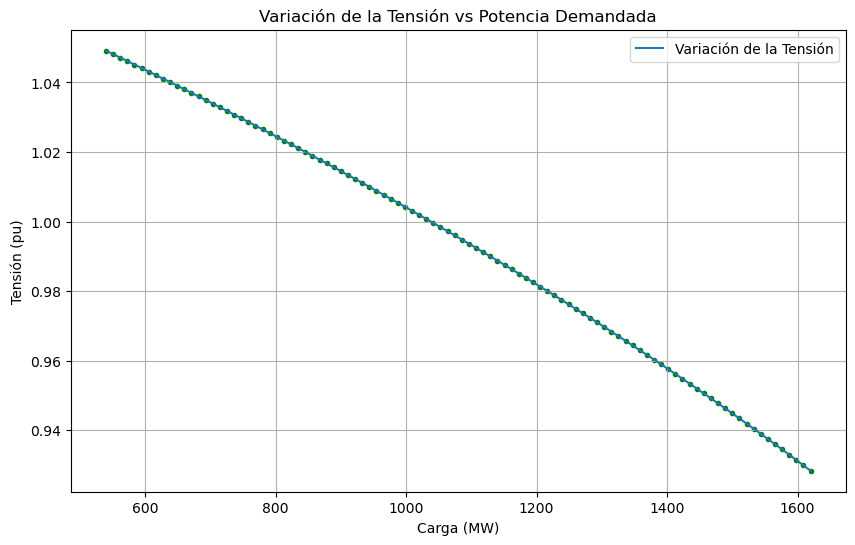

In [75]:
import pandapower as pp
import pandapower.plotting.plotly as pplot
import matplotlib.pyplot as plt
import numpy as np

# Crear una red vacía
net = pp.create_empty_network()

# Crear un nuevo tipo de línea
line_data = {"r_ohm_per_km": 0.02, "x_ohm_per_km": 0.115, "c_nf_per_km": 19.1, "max_i_ka": 1., "type": "line"}
pp.create_std_type(net, line_data, "linea")

# Crear barras (buses)
b1 = pp.create_bus(net, vn_kv=500.)
b2 = pp.create_bus(net, vn_kv=500.)

# Crear una línea utilizando el nuevo tipo de línea
linea1 = pp.create_line(net, from_bus=b1, to_bus=b2, length_km=500., std_type="linea", name="linea1", parallel=2)

# Crear una barra externa
pp.create_ext_grid(net, bus=b1, vm_pu=1., name="barra_ext")

# Valores nominales de carga (puedes ajustarlos según sea necesario)
p_nom = 1080  # MW
q_nom = 522.3   # MVAR

# Crear carga inicial
pp.create_load(net, bus=b2, p_mw=p_nom, q_mvar=q_nom, name="carga1")

# Inicializar listas para almacenar resultados
loads = []
voltages = []

# Rango de variación de la carga (-50% a +50%)
p_range = np.linspace(0.5 * p_nom, 1.5 * p_nom, 100)
q_range = np.linspace(0.5 * q_nom, 1.5 * q_nom, 100)

# Ejecutar flujo de potencia para cada valor de carga en el rango
for p, q in zip(p_range, q_range):
    # Actualizar la carga en la red
    net.load.at[0, 'p_mw'] = p
    net.load.at[0, 'q_mvar'] = q
        
    # Ejecutar el flujo de potencia
    pp.runpp(net)
        
    # Almacenar los resultados
    loads.append(p)
    voltages.append(net.res_bus.vm_pu[1])

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.scatter(loads, voltages, c='g', marker='.')
plt.plot(loads, voltages, label='Variación de la Tensión')
plt.xlabel('Carga (MW)')
plt.ylabel('Tensión (pu)')
plt.title('Variación de la Tensión vs Potencia Demandada')
plt.legend()
plt.grid()
plt.show()

Esta forma en la variación de la tensión se debe a que, cuanto mayor potencia sea consumida por la carga, mayor será la caída de tensión en la barra a la que se encuentre conectada, por lo tanto, para que llegue la tensión requerida es necesario compensar. La normativa dice que debe estar entre 1.03 y 0.97 pu.

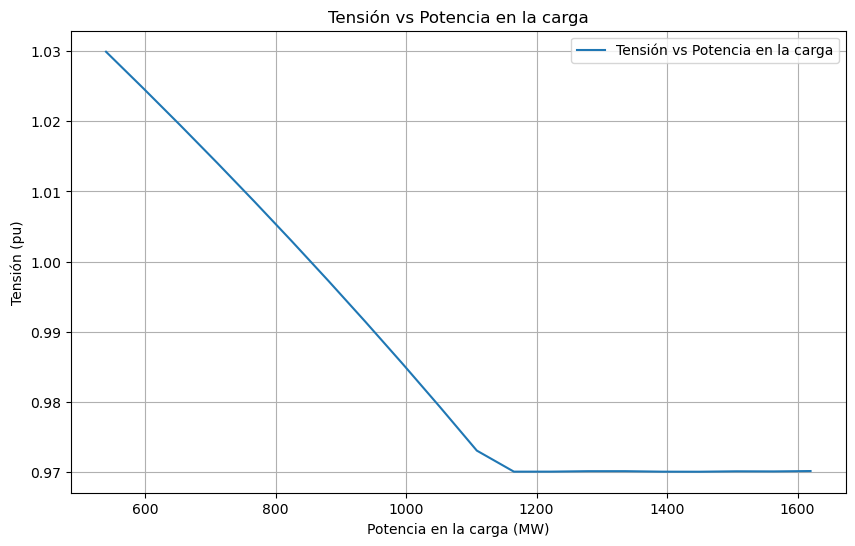

In [76]:
import pandapower as pp
import pandapower.plotting.plotly as pplot
import matplotlib.pyplot as plt
import numpy as np

# Crear una red vacía
net = pp.create_empty_network()

# Crear un nuevo tipo de línea
line_data = {"r_ohm_per_km": 0.02, "x_ohm_per_km": 0.115, "c_nf_per_km": 19.1, "max_i_ka": 1., "type": "line"}
pp.create_std_type(net, line_data, "linea")

# Crear barras (buses)
b1 = pp.create_bus(net, vn_kv=500.)
b2 = pp.create_bus(net, vn_kv=500.)

# Crear una línea utilizando el nuevo tipo de línea
linea1 = pp.create_line(net, from_bus=b1, to_bus=b2, length_km=500., std_type="linea", name="linea1", parallel=2)

# Crear una barra externa
pp.create_ext_grid(net, bus=b1, vm_pu=1., name="barra_ext")

# Valores nominales de carga (puedes ajustarlos según sea necesario)
p_nom = 1080  # MW
q_nom = 522.3   # MVAR

# Crear carga inicial
pp.create_load(net, bus=b2, p_mw=p_nom, q_mvar=q_nom, name="carga1")

# Inicializar listas para almacenar resultados
loads = []
voltages = []

# Rango de variación de la carga (-50% a +50%)
p_range = np.linspace(0.5 * p_nom, 1.5 * p_nom, 20)
q_range = np.linspace(0.5 * q_nom, 1.5 * q_nom, 20)

# Crear un shunt en la barra b2
shunt = pp.create_shunt(net, bus=b2, q_mvar=0., p_mw=0., vn_kv=500., name="shunt")

# Inicializar la susceptancia shunt
b = 0

# Ajustar la susceptancia shunt hasta que se cumplan las condiciones de tensión
for p, q in zip(p_range, q_range):
    # Actualizar la carga en la red
    net.load.at[0, 'p_mw'] = p
    net.load.at[0, 'q_mvar'] = q

    # Ajustar la susceptancia shunt
    while True:
        # Ejecutar el flujo de potencia
        pp.runpp(net)

        # Obtener el valor de tensión en la barra b2
        v = net.res_bus.vm_pu[1]

        # Verificar las condiciones de tensión
        if v > 1.03:
            # Si la tensión es demasiado alta, aumentar la susceptancia shunt (compensación capacitiva)
            b += 1
        elif v < 0.97:
            # Si la tensión es demasiado baja, disminuir la susceptancia shunt (compensación inductiva)
            b -= 1
        else:
            # Si las condiciones de tensión se cumplen, salir del bucle
            break

        # Actualizar la susceptancia shunt en la red
        net.shunt.at[shunt, 'q_mvar'] = b * v**2

    # Almacenar los resultados
    loads.append(p)
    voltages.append(v)
# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(loads, voltages, label='Tensión vs Potencia en la carga')
plt.xlabel('Potencia en la carga (MW)')
plt.ylabel('Tensión (pu)')
plt.title('Tensión vs Potencia en la carga')
plt.legend()
plt.grid()
plt.show()

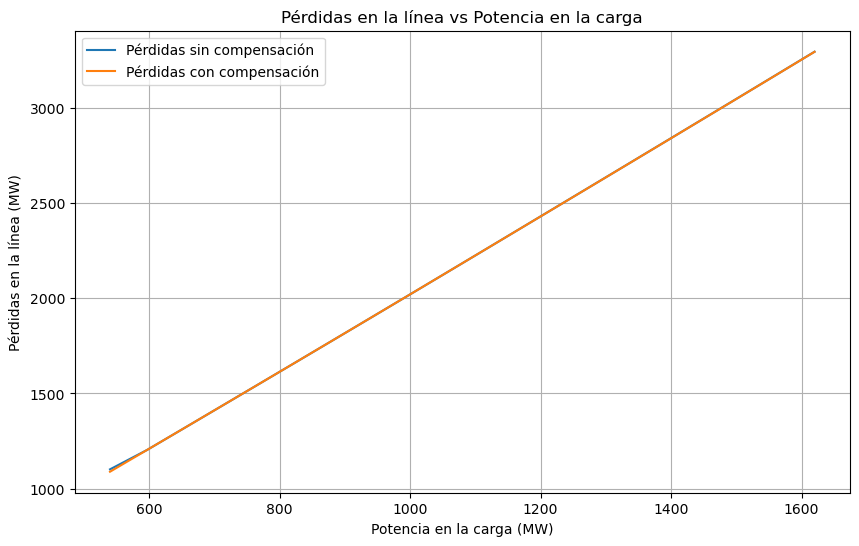

In [77]:
# Inicializar listas para almacenar las pérdidas en la línea
losses_with_compensation = []
losses_without_compensation = []

# Para cada valor en el rango de variación de la carga
for p, q in zip(p_range, q_range):
    # Actualizar la carga en la red
    net.load.at[0, 'p_mw'] = p
    net.load.at[0, 'q_mvar'] = q

    # Ejecutar el flujo de potencia
    pp.runpp(net)

    # Calcular las pérdidas en la línea y almacenarlas en la lista sin compensación
    losses_without_compensation.append(net.res_line.p_from_mw[0] - net.res_line.p_to_mw[0])

    # Ajustar la susceptancia shunt
    while True:
        # Ejecutar el flujo de potencia
        pp.runpp(net)

        # Obtener el valor de tensión en la barra b2
        v = net.res_bus.vm_pu[1]

        # Verificar las condiciones de tensión
        if v > 1.03:
            # Si la tensión es demasiado alta, aumentar la susceptancia shunt (compensación capacitiva)
            b += 1
        elif v < 0.97:
            # Si la tensión es demasiado baja, disminuir la susceptancia shunt (compensación inductiva)
            b -= 1
        else:
            # Si las condiciones de tensión se cumplen, salir del bucle
            break

        # Actualizar la susceptancia shunt en la red
        net.shunt.at[shunt, 'q_mvar'] = b * v**2

    # Calcular las pérdidas en la línea y almacenarlas en la lista con compensación
    losses_with_compensation.append(net.res_line.p_from_mw[0] - net.res_line.p_to_mw[0])

# Crear la figura
plt.figure(figsize=(10, 6))
plt.plot(loads, losses_without_compensation, label='Pérdidas sin compensación')
plt.plot(loads, losses_with_compensation, label='Pérdidas con compensación')
plt.xlabel('Potencia en la carga (MW)')
plt.ylabel('Pérdidas en la línea (MW)')
plt.title('Pérdidas en la línea vs Potencia en la carga')
plt.legend()
plt.grid()
plt.show()